In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:

# ----------------------------
# 1. Configuration
# ----------------------------
class Config:
    def __init__(self):
        self.sr = 32000           # Audio sample rate
        self.duration = 5         # Audio duration (seconds)
        self.n_mels = 128         # Number of Mel bands
        self.batch_size = 16      # Batch size (adjust per GPU memory)
        self.epochs = 20           # Number of epochs (increase for full training)
        self.lr = 1e-4            # Learning rate
        self.num_classes = 41     # Number of classes (as per train.csv)
        self.proj_dim = 128       # Projector output dimension for EPASS
        self.num_proj = 3         # Number of projectors to ensemble
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()


In [3]:

# ----------------------------
# 2. Audio Preprocessing Function
# ----------------------------
def preprocess_audio(path, sr=config.sr, duration=config.duration, n_mels=config.n_mels):
    # Load the audio file
    y, _ = librosa.load(path, sr=sr)
    max_len = sr * duration
    # Pad or truncate to fixed length
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]
    # Compute mel spectrogram (using keyword arguments)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Normalize to [0, 1]
    mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
    return mel_norm.astype(np.float32)  # shape: (n_mels, time)


In [4]:

# ----------------------------
# 3. Dataset Classes
# ----------------------------
class FreesoundDataset(Dataset):
    def __init__(self, df, audio_dir, label_map, transform=preprocess_audio):
        self.df = df
        self.audio_dir = audio_dir
        self.label_map = label_map
        self.transform = transform
        self.fnames = df.index.tolist()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        file_path = os.path.join(self.audio_dir, fname)
        mel = self.transform(file_path)
        # Add channel dimension: (1, n_mels, time)
        mel_tensor = torch.tensor(mel).unsqueeze(0)
        label = self.label_map[self.df.loc[fname, 'label']]
        return mel_tensor, label

class FreesoundTestDataset(Dataset):
    def __init__(self, df, audio_dir, label_map, transform=preprocess_audio):
        self.df = df
        self.audio_dir = audio_dir
        self.label_map = label_map
        self.transform = transform
        self.fnames = df.index.tolist()
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        file_path = os.path.join(self.audio_dir, fname)
        mel = self.transform(file_path)
        mel_tensor = torch.tensor(mel).unsqueeze(0)
        label = self.label_map[self.df.loc[fname, 'label']]
        return mel_tensor, label


In [5]:

# ----------------------------
# 4. Prepare Metadata and Label Map
# ----------------------------
# Load training CSV (for training)
train_df = pd.read_csv("../input/freesound-audio-tagging/train.csv")
train_df.set_index("fname", inplace=True)

# Load test_post_competition.csv (evaluation set with ground-truth labels)
test_df = pd.read_csv("../input/freesound-audio-tagging/test_post_competition.csv")
test_df = test_df.dropna(subset=['label'])  # Filter out rows with missing labels
test_df.set_index("fname", inplace=True)

# Create label mapping (alphabetical order)
labels = sorted(train_df['label'].unique())
label_map = {label: idx for idx, label in enumerate(labels)}


In [6]:

# ----------------------------
# 5. Define the EPASS Model
# ----------------------------
class EPASSModel(nn.Module):
    def __init__(self, proj_dim, num_proj, num_classes):
        super(EPASSModel, self).__init__()
        # Use a pretrained ResNet18 and modify first conv for 1-channel input.
        base_model = models.resnet18(pretrained=True)
        base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Remove the final fc layer.
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        self.out_dim = 512  # ResNet18 outputs 512-dim features
        # EPASS: multiple projector heads
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.out_dim, proj_dim),
                nn.ReLU(),
                nn.Linear(proj_dim, proj_dim)
            ) for _ in range(num_proj)
        ])
        # Final classifier using ensembled projector output
        self.classifier = nn.Linear(proj_dim, num_classes)
    
    def forward(self, x):
        # x: (batch, 1, n_mels, time)
        feat = self.encoder(x)           # -> (batch, 512, 1, 1)
        feat = feat.view(feat.size(0), -1) # -> (batch, 512)
        proj_list = [proj(feat) for proj in self.projectors]  # List of (batch, proj_dim)
        proj_ensemble = torch.stack(proj_list, dim=0).mean(dim=0)  # Average ensemble
        logits = self.classifier(proj_ensemble)
        return logits

# Instantiate the model and send to device.
model = EPASSModel(proj_dim=config.proj_dim, num_proj=config.num_proj, num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [7]:
# ----------------------------
# 6. Create DataLoaders (Train/Validation/Test)
# ----------------------------
audio_train_dir = "../input/freesound-audio-tagging/audio_train/"
audio_test_dir  = "../input/freesound-audio-tagging/audio_test/"

# Split train_df into training and validation using StratifiedKFold.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_indices, val_indices = next(skf.split(train_df, train_df['label']))
train_data = train_df.iloc[train_indices]
val_data = train_df.iloc[val_indices]

train_dataset = FreesoundDataset(train_data, audio_train_dir, label_map, transform=preprocess_audio)
val_dataset = FreesoundDataset(val_data, audio_train_dir, label_map, transform=preprocess_audio)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

test_dataset = FreesoundTestDataset(test_df, audio_test_dir, label_map, transform=preprocess_audio)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)


In [8]:

# ----------------------------
# 7. Define Training and Evaluation Functions
# ----------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [9]:

# ----------------------------
# 8. Training Loop with History Logging
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)

train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = 0.0
for epoch in range(config.epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, config.device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, config.device)
    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{config.epochs} - Train Loss: {tr_loss:.4f}, Train Acc: {tr_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

# Load best model for final evaluation.
model.load_state_dict(torch.load("best_model.pth"))

Epoch 1/20 - Train Loss: 2.5280, Train Acc: 0.3449 | Val Loss: 1.6343, Val Acc: 0.5573
Epoch 2/20 - Train Loss: 1.3453, Train Acc: 0.6400 | Val Loss: 1.0440, Val Acc: 0.7182
Epoch 3/20 - Train Loss: 0.8899, Train Acc: 0.7585 | Val Loss: 0.9187, Val Acc: 0.7541
Epoch 4/20 - Train Loss: 0.6296, Train Acc: 0.8262 | Val Loss: 0.8712, Val Acc: 0.7646
Epoch 5/20 - Train Loss: 0.4081, Train Acc: 0.8893 | Val Loss: 0.8705, Val Acc: 0.7805
Epoch 6/20 - Train Loss: 0.2754, Train Acc: 0.9203 | Val Loss: 0.9194, Val Acc: 0.7863
Epoch 7/20 - Train Loss: 0.2080, Train Acc: 0.9429 | Val Loss: 0.8500, Val Acc: 0.8011
Epoch 8/20 - Train Loss: 0.1553, Train Acc: 0.9559 | Val Loss: 0.9214, Val Acc: 0.7836
Epoch 9/20 - Train Loss: 0.1424, Train Acc: 0.9609 | Val Loss: 1.0521, Val Acc: 0.7726
Epoch 10/20 - Train Loss: 0.1245, Train Acc: 0.9637 | Val Loss: 1.1133, Val Acc: 0.7736
Epoch 11/20 - Train Loss: 0.0983, Train Acc: 0.9715 | Val Loss: 1.0829, Val Acc: 0.7715
Epoch 12/20 - Train Loss: 0.1035, Train A

<ipython-input-9-25c35984c2f0>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>


Test Loss: 0.7525, Test Accuracy: 0.8213

Classification Report:
                       precision    recall  f1-score   support

      Acoustic_guitar       0.93      0.93      0.93        45
             Applause       0.86      1.00      0.93        32
                 Bark       0.92      0.82      0.87        28
            Bass_drum       1.00      0.89      0.94        28
Burping_or_eructation       0.86      1.00      0.93        32
                  Bus       0.68      0.60      0.64        25
                Cello       0.86      0.94      0.90        54
                Chime       0.82      0.79      0.81        29
             Clarinet       0.91      0.93      0.92        56
    Computer_keyboard       0.83      0.73      0.78        26
                Cough       0.64      0.90      0.75        30
              Cowbell       0.91      0.98      0.94        42
          Double_bass       0.87      0.97      0.92        40
 Drawer_open_or_close       0.78      0.62      0.6

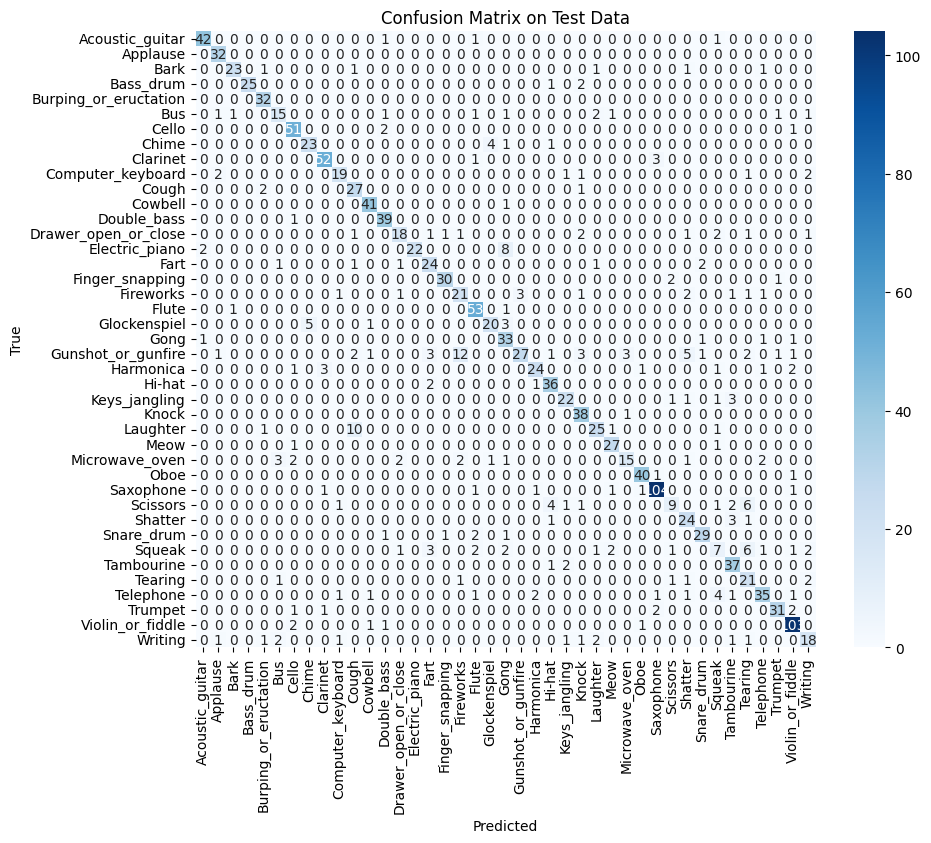

In [10]:
# ----------------------------
# 9. Evaluate on Test and Compute Metrics
# ----------------------------
test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion, config.device)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()


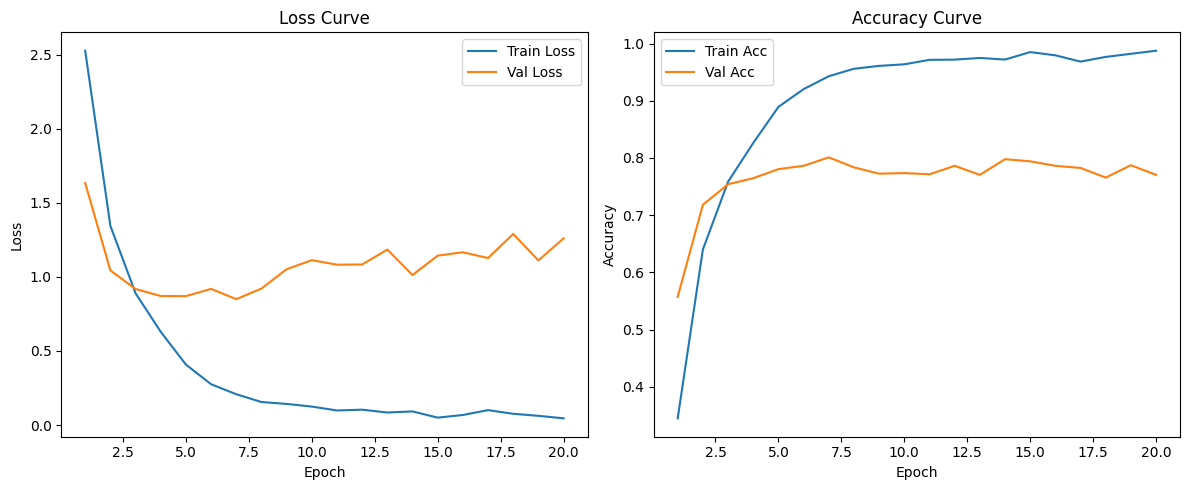

In [11]:
# ----------------------------
# 10. Plot Training Curves
# ----------------------------
epochs_range = range(1, config.epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()